# Notebook for new features development

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from dpet.ensemble_analysis import EnsembleAnalysis
from dpet.ensemble import Ensemble
from dpet.visualization import plot_comparison_matrix, Visualization
from dpet.data.comparison import (
    score_avg_jsd, score_ajsd_d, score_ajsd_t, score_emd_approximation
)


ensembles = [
    Ensemble(code='PED00157e001', database='ped'),
    Ensemble(code='PED00156e001', database='ped'),
    Ensemble(code='PED00158e001', database='ped')
]
data_dir = '/home/giacomo/projects/ensemble_analysis/out'

analysis = EnsembleAnalysis(ensembles, data_dir)
analysis.load_trajectories()

Ensemble PED00157e001 already downloaded. Skipping.
File PED00157e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00157e001.
Ensemble PED00156e001 already downloaded. Skipping.
File PED00156e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00156e001.
Ensemble PED00158e001 already downloaded. Skipping.
File PED00158e001.pdb already exists. Skipping extraction.
Trajectory file already exists for ensemble PED00158e001.
Loading trajectory for PED00157e001...
Loading trajectory for PED00156e001...
Loading trajectory for PED00158e001...


{'PED00157e001': <mdtraj.Trajectory with 100 frames, 939 atoms, 59 residues, without unitcells at 0x7fc0631f3ee0>,
 'PED00156e001': <mdtraj.Trajectory with 100 frames, 941 atoms, 59 residues, without unitcells at 0x7fc06280be50>,
 'PED00158e001': <mdtraj.Trajectory with 88 frames, 939 atoms, 59 residues, without unitcells at 0x7fc062827dc0>}

# High level (moderate control)

Quickly plot comparison matrices using a single method from the `visualization` module.

Setup.

In [2]:
# Initialize.
visualization = Visualization(analysis)

In [3]:
# Comparisons parameters.
bootstrap_iters = 5
bins = "auto"

Comparing ensembles with JSD scores.

# Scoring 'jsd' using features 'ca_dist'
- Number of bins for all comparisons: 10
- Will perform: 6 (pairs of ensembles) x 5 (iterations) = 30 (comparisons)
# Scoring 'jsd' using features 'alpha_angle'
- Number of bins for all comparisons: 10
- Will perform: 6 (pairs of ensembles) x 5 (iterations) = 30 (comparisons)


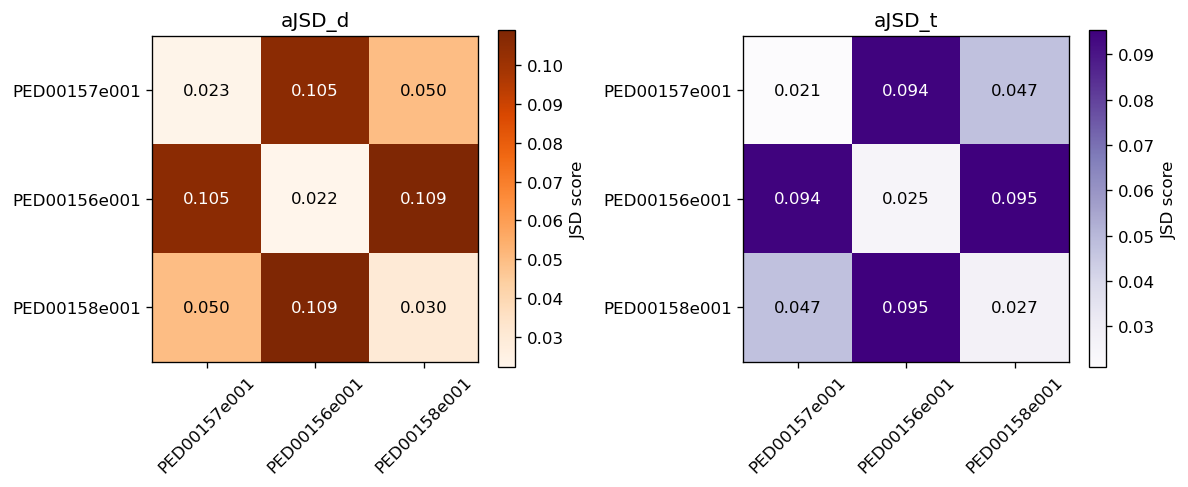

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10.0, 4), dpi=120)

visualization.comparison_matrix(
    score="jsd",
    feature="ca_dist",
    bootstrap_iters=bootstrap_iters,
    bins="auto",
    ax=ax[0],
    cmap="Oranges",
    verbose=True
)

visualization.comparison_matrix(
    score="jsd",
    feature="alpha_angle",
    bootstrap_iters=bootstrap_iters,
    bins="auto",
    ax=ax[1],
    cmap="Purples",
    verbose=True
)

plt.tight_layout()
plt.show()

Comparing ensembles with EMD scores.

# Scoring 'emd' using features 'ca_dist'
- Distance function for comparing: rmsd
- Will perform: 6 (pairs of ensembles) x 5 (iterations) = 30 (comparisons)
# Scoring 'emd' using features 'alpha_angle'
- Distance function for comparing: angular_l2
- Will perform: 6 (pairs of ensembles) x 5 (iterations) = 30 (comparisons)


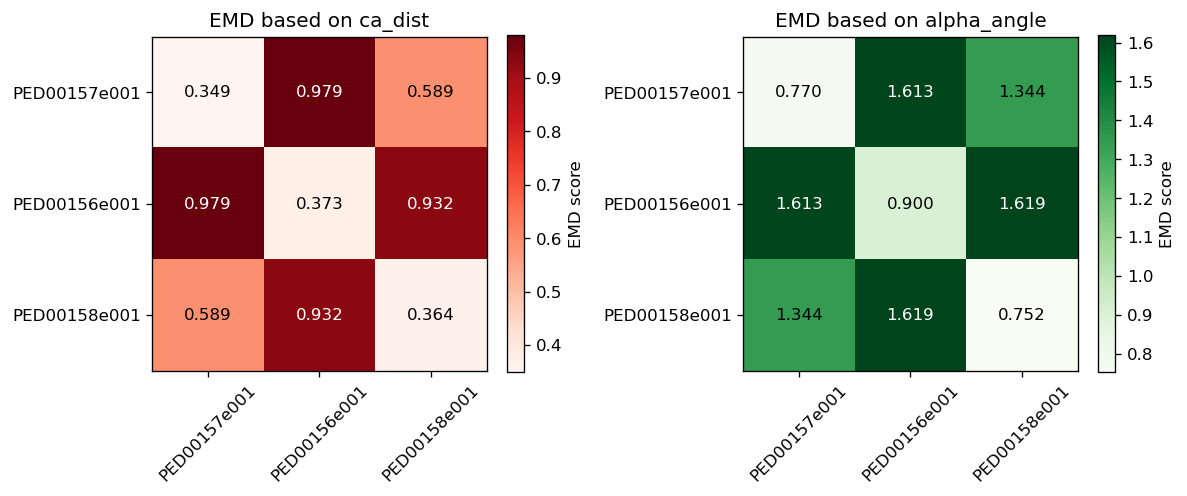

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10.0, 4), dpi=120)

visualization.comparison_matrix(
    score="emd",
    feature="ca_dist",
    bootstrap_iters=bootstrap_iters,
    bins="auto",
    ax=ax[0],
    cmap="Reds",
    verbose=True
)

visualization.comparison_matrix(
    score="emd",
    feature="alpha_angle",
    bootstrap_iters=bootstrap_iters,
    bins="auto",
    ax=ax[1],
    cmap="Greens",
    verbose=True
)

plt.tight_layout()
plt.show()

# Optional: intermediate level (slightly more control)

We manually compute all vs all JSD scores via the `EnsembleAnalysis` class and then plot. Similar to the example above, but now we have more steps.

First, let's analyze different features (in this example: Ca-Ca distances and alpha angles).

In [6]:
boostrap_iters = 5
bins = "auto"
score = "jsd"

# Score divergences in Ca-Ca distances.
ca_dist_scores, codes = analysis.comparison_scores(
    score=score,
    feature="ca_dist",
    bins=bins,
    bootstrap_iters=boostrap_iters,
    verbose=True
)

# Score divergences in alpha torsions.
alpha_angles_scores, codes = analysis.comparison_scores(
    score=score,
    feature="alpha_angle",
    bins=bins,
    bootstrap_iters=boostrap_iters,
    verbose=True
)

# Scoring 'jsd' using features 'ca_dist'
- Number of bins for all comparisons: 10
- Will perform: 6 (pairs of ensembles) x 5 (iterations) = 30 (comparisons)
# Scoring 'jsd' using features 'alpha_angle'
- Number of bins for all comparisons: 10
- Will perform: 6 (pairs of ensembles) x 5 (iterations) = 30 (comparisons)


Then we plot the results of the comparisons using the `dpet.visualization.plot_comparison_matrix` method.

We need to create our own `fig` and `ax` objects with matplotlib.

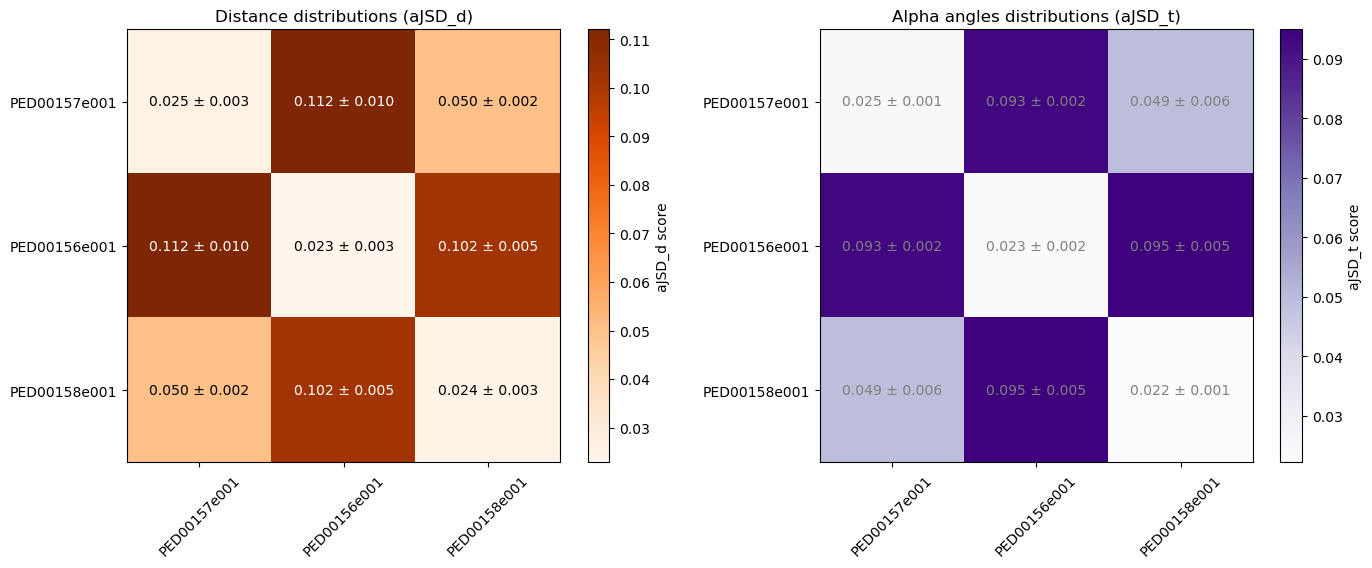

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14.0, 5.5))

show_std = True
plot_comparison_matrix(
    ax=ax[0],
    scores=ca_dist_scores,
    codes=codes,
    std=show_std,
    cmap="Oranges",
    title="Distance distributions (aJSD_d)",
    cbar_label="aJSD_d score",
    textcolors=("black", "white")
)
plot_comparison_matrix(
    ax=ax[1],
    scores=alpha_angles_scores,
    codes=codes,
    std=show_std,
    cmap="Purples",
    title="Alpha angles distributions (aJSD_t)",
    cbar_label="aJSD_t score",
    textcolors="gray"  # Changes text color.
)
plt.tight_layout()
plt.show()

# Optional: low level (full control)

Manually compare a pair of ensembles.

Get the ensembles to compare

In [8]:
ens_1 = analysis["PED00157e001"]
ens_2 = analysis["PED00156e001"]

Easy, quick way to compute aJSD_d and aJSD_t.

In [9]:
score, bins = score_ajsd_d(ens_1, ens_2, bins="auto", return_bins=True)
print(f"- aJSD_d score: {score:.4f}, bins used: {bins}")

score, bins = score_ajsd_t(ens_1, ens_2, bins="auto", return_bins=True)
print(f"- aJSD_t score: {score:.4f}, bins used: {bins}")

- aJSD_d score: 0.0825, bins used: 10
- aJSD_t score: 0.0709, bins used: 10


There is also a more complex way to compute aJSD values. We only show how to do it for aJSD_t, aJSD_d is similar.

You can adapt it for any feature matrix of shape `(N, F)`.

You can also implement your own bootstrapping strategy with this system.

In [10]:
# Manually compute features (alpha_angles).
alpha_1 = ens_1.get_features(featurization="a_angle")
print("- features 1 shape:", alpha_1.shape)
alpha_2 = ens_2.get_features(featurization="a_angle")
print("- features 2 shape:", alpha_2.shape)

# Manually compute average JSD approximation. You can also provide any other
# 2d feature matrix as input to the `score_avg_jsd` function.
score, bins = score_avg_jsd(alpha_1, alpha_2, bins="auto", return_bins=True)
print(f"- aJSD_t score: {score:.4f}, bins used: {bins}")

- features 1 shape: (100, 56)
- features 2 shape: (100, 56)
- aJSD_t score: 0.0709, bins used: 10


Finally, let's also manually compare ensembles with EMD scores.

You can adapt this code to any feature matrix of shape `(N, F)`.

In [11]:
# Let's compute features (alpha_angles).
alpha_1 = ens_1.get_features(featurization="a_angle")
print("- features 1 shape:", alpha_1.shape)
alpha_2 = ens_2.get_features(featurization="a_angle")
print("- features 2 shape:", alpha_2.shape)

# Manually score EMD approximation. NOTE: since we are comparing angular features,
# make sure to use `angular_l2` as the `metric` argument. For all other features
# (e.g.: interatomic distances) you should use `rmsd` or `l2` instead.
score = score_emd_approximation(alpha_1, alpha_2, metric="angular_l2")
print(f"- EMD on alpha angles: {score:.4f}")

- features 1 shape: (100, 56)
- features 2 shape: (100, 56)
- EMD on alpha angles: 1.5591
